In [1]:
%load_ext autoreload
%autoreload 2
from cmip6_downscaling.methods.common.utils import zmetadata_exists
from upath import UPath
import xarray as xr
from cmip6_downscaling.methods.common.bias_correction import bias_correct_obs_by_method, bias_correct_gcm_by_method
# from cmip6_downscaling.data.observations import open_era5
# from cmip6_downscaling.methods.bcsd.tasks import fit_and_predict
import os
import fsspec
import rechunker
import zarr
from sklearn.exceptions import DataConversionWarning
import warnings

connection_string = os.environ.get("AZURE_STORAGE_CONNECTION_STRING")
fs = fsspec.filesystem('az', connection_string=connection_string)


In [2]:
from dask.distributed import Client

client = Client()
client

Connection method: Cluster object,Cluster type: distributed.LocalCluster
Dashboard: http://127.0.0.1:8787/status,
Dashboard: http://127.0.0.1:8787/status,Workers: 8
Total threads: 32,Total memory: 251.72 GiB
Status: running,Using processes: True
Comm: tcp://127.0.0.1:40765,Workers: 8
Dashboard: http://127.0.0.1:8787/status,Total threads: 32
Started: Just now,Total memory: 251.72 GiB
Comm: tcp://127.0.0.1:34317,Total threads: 4
Dashboard: http://127.0.0.1:45141/status,Memory: 31.46 GiB
Nanny: tcp://127.0.0.1:44029,


In [3]:
xtrain_path = 'az://flow-outputs/gard_test_intermediate/0.0.post546+dirty/rechunk/f8c4e065280b2c84'
ytrain_path = 'az://flow-outputs/gard_test_intermediate/0.0.post546+dirty/rechunk/e4d073b3764113f5'
xpred_path = 'az://flow-outputs/gard_test_intermediate/0.0.post546+dirty/rechunk/3fcfde5ec93241d0'

In [13]:
xtrain = xr.open_zarr(xtrain_path).persist()  # .isel(lon=slice(0, 48*6), lat=slice(0, 48*6))
ytrain = xr.open_zarr(ytrain_path).persist()  # .isel(lon=slice(0, 48*6), lat=slice(0, 48*6))
xpred = xr.open_zarr(xpred_path).persist()  # .isel(lon=slice(0, 48*6), lat=slice(0, 48*6))

# make sure you have the variables you need in obs
for v in xpred.data_vars:
    assert v in ytrain.data_vars

# _fit_wrapper(xtrain, ytrain)
# data transformation (this wants full-time chunking)
# transformed_obs is for the training period

# we need two transformed gcms - one for training and one for prediction
# for transformed gcm_train we pass the same thing as the training and the
# prediction since we're just transforming it
# Create a template dataset for map blocks
# This feals a bit fragile.
template_var = list(xpred.data_vars.keys())[0]
# .to_dataarray(dim='variable')
template_da = xpred[template_var]
template = xr.Dataset()
for var in ['pred', 'exceedance_prob', 'prediction_error']:
    template[var] = template_da

In [5]:
from cmip6_downscaling.methods.gard.tasks import _fit_and_predict_wrapper

/srv/conda/envs/notebook/lib/python3.9/site-packages/carbonplan_data/__init__.py:29: UserWarning: CARBONPLAN_DATA environment variable not set, `carbonplan.data.cat` may not work as expected.Known data locations include: ['https://storage.googleapis.com/carbonplan-data', 'https://carbonplan.blob.core.windows.net/carbonplan-data'].
  warnings.warn(msg)


In [16]:
client.restart()

Connection method: Cluster object,Cluster type: distributed.LocalCluster
Dashboard: http://127.0.0.1:8787/status,
Dashboard: http://127.0.0.1:8787/status,Workers: 0
Total threads: 0,Total memory: 0 B
Status: running,Using processes: True
Comm: tcp://127.0.0.1:37689,Workers: 0
Dashboard: http://127.0.0.1:8787/status,Total threads: 0
Started: 12 minutes ago,Total memory: 0 B


In [6]:
run_parameters = {'method': 'gard', 
                  'obs': 'ERA5', 
                  'model': 'MIROC6', 
                  'scenario': 'ssp370', 
                  'grid_label': 'gn', 'table_id': 'day', 'member': 'r1i1p1f1', 'features': ['tasmax'], 
                  'variable': 'tasmax', 'train_period': ['1981', '2010'], 
                  'predict_period': ['2015', '2099'], 'latmin': '-90', 
                  'latmax': '90', 'lonmin': '-180', 'lonmax': '180', 
                  'bias_correction_method': 'quantile_transform', 
                  'bias_correction_kwargs': {}, 'model_type': 'PureRegression', 'model_params': {}}

In [12]:
xtrain

,Array,Chunk
Bytes,42.38 GiB,96.30 MiB
Shape,"(10957, 721, 1440)","(10957, 48, 48)"
Count,481 Tasks,480 Chunks
Type,float32,numpy.ndarray


In [7]:
xtrain_subset = xtrain.isel(lat=slice(0,240), lon=slice(0,240)).persist()
xpred_subset = xpred.isel(lat=slice(0,240), lon=slice(0,240)).persist()
ytrain_subset = ytrain.isel(lat=slice(0,240), lon=slice(0,240)).persist()

In [8]:
template_var = list(xpred_subset.data_vars.keys())[0]
# .to_dataarray(dim='variable')
template_da = xpred_subset[template_var]
template = xr.Dataset()
for var in ['pred', 'exceedance_prob', 'prediction_error']:
    template[var] = template_da

In [9]:
out = xr.map_blocks(
    _fit_and_predict_wrapper,xtrain_subset
    ,
    args=(ytrain_subset, 
          xpred_subset.rename({'time': 't2'}), run_parameters),
    kwargs={'dim': 'time'},
    template=template,
)

In [17]:
client.cancel(ytrain_subset)

In [10]:
out = out.persist()

/srv/conda/envs/notebook/lib/python3.9/site-packages/carbonplan_data/__init__.py:29: UserWarning: CARBONPLAN_DATA environment variable not set, `carbonplan.data.cat` may not work as expected.Known data locations include: ['https://storage.googleapis.com/carbonplan-data', 'https://carbonplan.blob.core.windows.net/carbonplan-data'].
  warnings.warn(msg)
/srv/conda/envs/notebook/lib/python3.9/site-packages/carbonplan_data/__init__.py:29: UserWarning: CARBONPLAN_DATA environment variable not set, `carbonplan.data.cat` may not work as expected.Known data locations include: ['https://storage.googleapis.com/carbonplan-data', 'https://carbonplan.blob.core.windows.net/carbonplan-data'].
  warnings.warn(msg)
/srv/conda/envs/notebook/lib/python3.9/site-packages/carbonplan_data/__init__.py:29: UserWarning: CARBONPLAN_DATA environment variable not set, `carbonplan.data.cat` may not work as expected.Known data locations include: ['https://storage.googleapis.com/carbonplan-data', 'https://carbonplan.

In [11]:
out.to_zarr('az://scratch/junk.zarr')

In [14]:
out

<xarray.Dataset>
Dimensions:           (lat: 480, lon: 480, time: 31046)
Coordinates:
  * lat               (lat) float64 -90.0 -89.75 -89.5 ... 29.25 29.5 29.75
  * lon               (lon) float64 -180.0 -179.8 -179.5 ... -60.75 -60.5 -60.25
  * time              (time) datetime64[ns] 2015-01-01 2015-01-02 ... 2099-12-31
Data variables:
    pred              (time, lat, lon) float32 dask.array<chunksize=(31046, 48, 48), meta=np.ndarray>
    exceedance_prob   (time, lat, lon) float32 dask.array<chunksize=(31046, 48, 48), meta=np.ndarray>
    prediction_error  (time, lat, lon) float32 dask.array<chunksize=(31046, 48, 48), meta=np.ndarray>

In [ ]:
out.attrs.update({'title': 'gard_fit_and_predict'}, **get_cf_global_attrs(version=version))
print(out)
# out = wait(out.persist())
t = out.to_zarr(target, mode='w') 

In [7]:
fs.rm('az://flow-outputs/gard_test_intermediate/0.0.post546+dirty/regrid', recursive=True)

In [10]:
ds = xr.open_zarr('az://flow-outputs/gard_test_intermediate/0.0.post546+dirty/regrid/fd0547ca98fa4fb2')

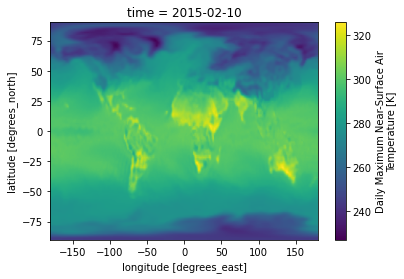

In [12]:
ds.isel(time=40).tasmax.plot()

In [16]:
fs.rm('az://flow-outputs/gard_test_intermediate/0.0.post546+dirty/gard_fit_and_predict/a44a50638ca8c3ac/', recursive=True)

In [4]:
ds = xr.open_zarr('az://flow-outputs/gard_test_result/0.0.post546+dirty/daily/800b9d58689bb76d')

In [23]:
target = (intermediate_dir) / (UPath(str("rechunk_" + pattern_string + '_'+ str(path).split(str(intermediate_dir))[1].split('/')[-1])))

In [21]:
str(path).split(str(intermediate_dir))[1].split('/')[-1]

SyntaxError: unmatched ')' (3669724782.py, line 1)

In [24]:
print(target)

az:/flow-outputs/intermediates/0_0_post522+dirty/rechunk_full_space_ERA5_tasmax_-90_90_-180_180_1981_2010


In [1]:
testing = 'a'

In [3]:
print('too bad {testing}')

too bad {testing}
